In [13]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load the JSON file
data = pd.read_json('../../generated/VUEs.json')

# Convert to a DataFrame
df = pd.DataFrame(data)


# Normalize the 'revisedProteinEffects' column
normalized_dfs = []
for index, row in df.iterrows():
    normalized_row = pd.json_normalize(row['revisedProteinEffects'])
    repeated_row = pd.DataFrame([row.drop('revisedProteinEffects')] * len(normalized_row)).reset_index(drop=True)
    combined = pd.concat([repeated_row.reset_index(drop=True), normalized_row], axis=1).reset_index(drop=True)
    normalized_dfs.append(combined)

# Determine the union of all column names
all_columns = set()
for df in normalized_dfs:
    all_columns.update(df.columns)

# Reindex each DataFrame to include all columns, filling missing values with NaN
all_columns = list(all_columns)
for i, df in enumerate(normalized_dfs):
    normalized_dfs[i] = df.loc[:, ~df.columns.duplicated()].reindex(columns=all_columns)

# Concatenate all normalized DataFrames
result_df = pd.concat(normalized_dfs, ignore_index=True)
# make anything CountByVariantCount 0
count_cancer_type_columns = [col for col in result_df.columns if 'CountByCancerType' in col]
result_df[count_cancer_type_columns] = result_df[count_cancer_type_columns].fillna(0).astype(int)

In [14]:
# hardcoded set o fgene swith highest level (manually determined with
# mutationmapper, and just looking upn genes in OncoKB)
highest_level_per_gene = {
    "KIT": "Level 1",
    "MET": "Level 1",
    "FLT3": "Level 1",
    "ATM": "Level 1",
    "BRCA1": "Level 1",
    "BRCA2": "Level 1",
    "BRIP1": "Level 1",
    "CHEK2": "Level 1",
    "PALB2": "Level 1",
    "RAD51D": "Level 1",
    "MLH1": "Level 1",
    "EGFR": "Level 1",
    "KRAS": "Level 2",
}

In [15]:
# Custom function to calculate the sum
def custom_sum(row):
    result = {}
    for study in "tcga mskimpact mskimpact_nonsignedout genie total".split():
        result[study] = (
            row[f'counts.{study}.somaticVariantsCount'].sum() +
            row[f'counts.{study}.germlineVariantsCount'].sum() +
            row[f'counts.{study}.unknownVariantsCount'].sum()
        )
        # result[f'{study}.totalPatientCount'] = row[f'counts.{study}.totalPatientCount'].values[0]
        
    for cancer_type in cancer_types:
        result[f'counts.CancerType.{cancer_type}'] = 0
        for study in "total".split():
            result[f'counts.CancerType.{cancer_type}'] += (
                row.get(f'counts.{study}.somaticVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
                row.get(f'counts.{study}.germlineVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
                row.get(f'counts.{study}.unknownVariantsCountByCancerType.{cancer_type}', np.array(0)).sum()
            )
    return pd.Series(result)

cancer_types = set([c.split('.')[-1] for c in result_df.columns if "CancerType" in c])

# Group by 'hugoGeneSymbol' and apply custom function
grouped_df = result_df.groupby('hugoGeneSymbol').apply(custom_sum)


# Add additional columns
grouped_df['Number of VUEs'] = result_df.groupby('hugoGeneSymbol').size()
grouped_df['total_variant_count'] = grouped_df['total']
grouped_df['Highest_Level'] = grouped_df.index.map(highest_level_per_gene).fillna('Oncogenic')
grouped_df['total_patient_count'] = grouped_df['total_variant_count']

In [16]:
# check for any VUEs with 0 variants
zero_variant_cases = grouped_df[grouped_df['total'] == 0]
print("There are {} VUEs with 0 variants".format(len(zero_variant_cases)))
print(zero_variant_cases)

There are 0 VUEs with 0 variants
Empty DataFrame
Columns: [tcga, mskimpact, mskimpact_nonsignedout, genie, total, counts.CancerType.B-Lymphoblastic Leukemia/Lymphoma, counts.CancerType.Miscellaneous Brain Tumor, counts.CancerType.Medulloblastoma, counts.CancerType.Vaginal Cancer, counts.CancerType.Mature B-Cell Neoplasms, counts.CancerType.Thyroid Cancer, counts.CancerType.Bone Cancer, counts.CancerType.Leukemia, counts.CancerType.CNS Cancer, counts.CancerType.Pheochromocytoma, counts.CancerType.Appendiceal Cancer, counts.CancerType.Small Cell Lung Cancer, counts.CancerType.Small Bowel Cancer, counts.CancerType.Esophagogastric Cancer, counts.CancerType.Head and Neck Cancer, counts.CancerType.Histiocytosis, counts.CancerType.Sellar Tumor, counts.CancerType.Nerve Sheath Tumor, counts.CancerType.Penile Cancer, counts.CancerType.Hodgkin Lymphoma, counts.CancerType.Peritoneal Cancer, NOS, counts.CancerType.Retinoblastoma, counts.CancerType.UNKNOWN, counts.CancerType.Melanoma, counts.CancerT

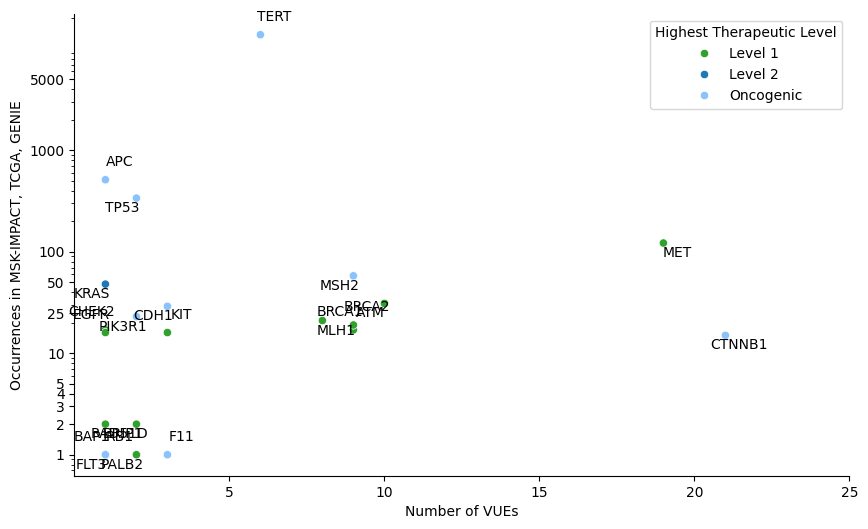

In [18]:
from matplotlib.ticker import MaxNLocator, LogLocator, ScalarFormatter

# Create the scatter plot
plt.figure(figsize=(10, 6))


palette = {"Level 1": "#30A12D", "Level 2": "#1f78b4", "Oncogenic": "#8bc2fc"}

scatter_plot = sns.scatterplot(data=grouped_df, x='Number of VUEs', y='total_variant_count', hue="Highest_Level", palette=palette)

# Despine the plot
sns.despine()

# Set x-axis to display integers only
scatter_plot.xaxis.set_major_locator(MaxNLocator(integer=True))
# Set y-axis to log scale
scatter_plot.set_yscale('log')
# Manually set y-axis ticks
scatter_plot.set_yticks([1, 2, 3, 4, 5, 10, 25, 50, 100, 1000, 5000])
scatter_plot.get_yaxis().set_major_formatter(ScalarFormatter())
scatter_plot.set_xticks([5, 10, 15, 20, 25])

# Add labels and title
scatter_plot.set_xlabel('Number of VUEs')
scatter_plot.set_ylabel('Occurrences in MSK-IMPACT, TCGA, GENIE')

# Reorder the legend handles and labels
handles, labels = scatter_plot.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]  # Swap the order of handles
labels = [labels[1], labels[2], labels[0]]  # Swap the order of labels
# Update the legend
scatter_plot.legend(handles, labels, title="Highest Therapeutic Level", loc="upper right")

# Add annotations for each point with gene symbols
texts = []
for i, row in grouped_df.iterrows():
    # Add some randomness to the initial text position
    x_offset = np.random.choice([-10,10])
    y_offset = np.random.choice([10, -10])
    texts.append(scatter_plot.annotate(row.name, 
                          (row['Number of VUEs'], row['total']),
                          textcoords="offset points", xytext=(x_offset, y_offset), ha='center', fontsize=10))

# plt.savefig("revue_occurrence_plot.svg", format='svg')

# Show the plot
plt.show()